In [1]:
from google.colab import drive
# Mount Google Drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [2]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 7.3 MB/s eta 0:00:00


In [3]:
import os
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import model_to_dot
from PIL import Image
from keras.applications import ResNet152V2
from keras.models import Sequential
from keras.layers import GaussianNoise, GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, Flatten
import json
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import shap

In [4]:
!unzip "/content/gdrive/MyDrive/Initial_50K.zip"

Streaming output truncated to the last 5000 lines.
  inflating: NSCLC_Radiomics_50k_splitted/validation/Large_cell_carcinoma/Large_cell_carcinoma_8423.png  
  inflating: NSCLC_Radiomics_50k_splitted/validation/Large_cell_carcinoma/Large_cell_carcinoma_8424.png  
  inflating: NSCLC_Radiomics_50k_splitted/validation/Large_cell_carcinoma/Large_cell_carcinoma_8437.png  
  inflating: NSCLC_Radiomics_50k_splitted/validation/Large_cell_carcinoma/Large_cell_carcinoma_8438.png  
  inflating: NSCLC_Radiomics_50k_splitted/validation/Large_cell_carcinoma/Large_cell_carcinoma_8445.png  
  inflating: NSCLC_Radiomics_50k_splitted/validation/Large_cell_carcinoma/Large_cell_carcinoma_8482.png  
  inflating: NSCLC_Radiomics_50k_splitted/validation/Large_cell_carcinoma/Large_cell_carcinoma_8486.png  
  inflating: NSCLC_Radiomics_50k_splitted/validation/Large_cell_carcinoma/Large_cell_carcinoma_849.png  
  inflating: NSCLC_Radiomics_50k_splitted/validation/Large_cell_carcinoma/Large_cell_carcinoma_8492.pn

In [5]:
import os
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define your custom data directory
custom_data_dir = '/content/NSCLC_Radiomics_50k_splitted'


In [6]:
# Define class names (modify this according to your dataset)
class_names = ["Adenocarcinoma", "Large cell carcinoma", "Normal", "Not otherwise specified", "Squamous cell carcinoma"]

In [7]:
train_ds = keras.utils.image_dataset_from_directory(
    f"{custom_data_dir}/train",
    labels='inferred',
    label_mode='int',
    batch_size=64,
    image_size=(300, 300)

)

test_ds = keras.utils.image_dataset_from_directory(
    f"{custom_data_dir}/test",
    labels='inferred',
    label_mode='int',
    batch_size=64,
    image_size=(300, 300)

)

val_ds = keras.utils.image_dataset_from_directory(
    f"{custom_data_dir}/validation",
    labels='inferred',
    label_mode='int',
    batch_size=64,
    image_size=(300, 300)

)

Found 35848 files belonging to 5 classes.
Found 7680 files belonging to 5 classes.
Found 7687 files belonging to 5 classes.


In [8]:
# Define the new image size
new_image_size = (100, 100)

# Function to resize images
def resize_image(image, label):
    image = tf.image.resize(image, new_image_size)
    return image, label

# Apply resizing to the datasets
train_ds = train_ds.map(resize_image)
test_ds = test_ds.map(resize_image)
val_ds = val_ds.map(resize_image)

In [9]:
# Normalize the pixel values
def preprocess(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)  # Convert to float32
    image = image / 255.0  # Normalize pixel values
    return image, label

# Apply preprocessing to the datasets
train_ds = train_ds.map(preprocess)
test_ds = test_ds.map(preprocess)
val_ds = val_ds.map(preprocess)

# One-hot encode the labels
num_classes = 5  # Update with the actual number of classes
train_ds = train_ds.map(lambda image, label: (image, tf.one_hot(label, num_classes)))
test_ds = test_ds.map(lambda image, label: (image, tf.one_hot(label, num_classes)))
val_ds = val_ds.map(lambda image, label: (image, tf.one_hot(label, num_classes)))

# Configure the datasets for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout

# Create a simple CNN model
cnn = Sequential()
cnn.add(Conv2D(64, (3, 3), activation='relu', input_shape=(100, 100, 3)))
cnn.add(MaxPooling2D((2, 2)))
cnn.add(Flatten())
cnn.add(Dense(256, activation='relu'))
cnn.add(Dropout(0.25))
cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.25))
cnn.add(Dense(64, activation='relu'))
cnn.add(Dropout(0.25))
cnn.add(Dense(5, activation='softmax'))

# Display the model summary
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 49, 49, 64)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 153664)            0         
                                                                 
 dense (Dense)               (None, 256)               39338240  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                        

In [11]:
''"""# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # You can choose any metric to monitor
    patience=10,          # Number of epochs with no improvement after which training will be stopped
    verbose=1,
    restore_best_weights=True  # Do restore best weights
)

# Compile the model
cnn.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
        tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top_5_categorical_accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.CosineSimilarity(name='cosine_similarity')
    ]
)

# Initialize variables to keep track of the best validation loss and corresponding model weights
best_val_loss = float('inf')
best_weights = None

# Lists to store training and validation metrics
cnn_train_losses = []
cnn_val_losses = []
cnn_train_accuracies = []
cnn_val_accuracies = []
cnn_train_precisions = []
cnn_val_precisions = []
cnn_train_recalls = []
cnn_val_recalls = []
cnn_train_cosine_similarity = []
cnn_val_cosine_similarity = []

for epoch in range(100):
    # Train the model for one epoch
    history = cnn.fit(train_ds, epochs=1, validation_data=val_ds, callbacks=[early_stopping])

    # Append training and validation metrics for plotting
    cnn_train_losses.append(history.history['loss'][0])
    cnn_val_losses.append(history.history['val_loss'][0])
    cnn_train_accuracies.append(history.history['categorical_accuracy'][0])
    cnn_val_accuracies.append(history.history['val_categorical_accuracy'][0])
    cnn_train_precisions.append(history.history['precision'][0])
    cnn_val_precisions.append(history.history['val_precision'][0])
    cnn_train_recalls.append(history.history['recall'][0])
    cnn_val_recalls.append(history.history['val_recall'][0])
    cnn_train_cosine_similarity.append(history.history['cosine_similarity'][0])
    cnn_val_cosine_similarity.append(history.history['val_cosine_similarity'][0])

    # Check if the current validation loss is better than the best seen so far
    if history.history['val_loss'][0] < best_val_loss:
        best_val_loss = history.history['val_loss'][0]
        best_weights = cnn.get_weights()
        # You can also save the weights to a file here if desired

# After training, you can set the model weights to the best weights
cnn.set_weights(best_weights)

# Now you have the training and validation metrics (loss, accuracy, precision, recall, and cosine similarity) stored in the respective lists.
"""''

"# Define early stopping callback\nearly_stopping = tf.keras.callbacks.EarlyStopping(\n    monitor='val_loss',  # You can choose any metric to monitor\n    patience=10,          # Number of epochs with no improvement after which training will be stopped\n    verbose=1,\n    restore_best_weights=True  # Do restore best weights\n)\n\n# Compile the model\ncnn.compile(\n    optimizer=tf.keras.optimizers.Adam(),\n    loss=tf.keras.losses.CategoricalCrossentropy(),\n    metrics=[\n        tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),\n        tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top_5_categorical_accuracy'),\n        tf.keras.metrics.Precision(name='precision'),\n        tf.keras.metrics.Recall(name='recall'),\n        tf.keras.metrics.CosineSimilarity(name='cosine_similarity')\n    ]\n)\n\n# Initialize variables to keep track of the best validation loss and corresponding model weights\nbest_val_loss = float('inf')\nbest_weights = None\n\n# Lists to store 

In [12]:
# Create an ImageDataGenerator for data loading and augmentation
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

# Load and preprocess your custom dataset
custom_data = data_generator.flow_from_directory(
    f"{custom_data_dir}/test",
    batch_size=64,
    shuffle=False  # Disable shuffling to ensure order of labels matches order of images
)

# Retrieve the input images and labels
X, y = custom_data.next()

Found 7680 images belonging to 5 classes.


In [13]:
# Resize the images to
resized_images = []
for image in X:
    pil_image = Image.fromarray(image.astype('uint8'))
    pil_image = pil_image.resize((100, 100), Image.ANTIALIAS)
    resized_image = np.array(pil_image)
    resized_images.append(resized_image)

# Convert the list of resized images back to a NumPy array
X_resized = np.array(resized_images)
y =  np.array(y)

<ipython-input-13-771bc82efe66>:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  pil_image = pil_image.resize((100, 100), Image.ANTIALIAS)


In [14]:
# python function to get model output; replace this function with your own model function.
def f(x):
    tmp = x.copy()
    preprocess_input(tmp)
    return cnn(tmp)


# define a masker that is used to mask out partitions of the input image.
masker = shap.maskers.Image("inpaint_telea", X_resized[0].shape)

# create an explainer with model and image masker
explainer = shap.Explainer(f, masker, output_names=class_names)

# here we explain two images using 100000 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(
    X_resized[1:2], max_evals=100000, batch_size=50, outputs=shap.Explanation.argsort.flip[:5]
)

  0%|          | 0/99998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [34:41, 2081.03s/it]             


In [23]:
def show_attributions(model, X, y, shap_values, class_names):
    # Assuming `tf` is tensorflow
    output = model(X_resized[1:2])

    # Get the index of the max log-probability
    pred = tf.argmax(output, axis=1)
    pred_np = pred.numpy()

    for i in range(len(X_resized[1:2])):
        # Prepare the attribution plot
        shap.image_plot(shap_values, X_resized[i:i+1], labels=shap_values.output_names, show=False)

        # Get the current figure and axes
        fig = plt.gcf()
        allaxes = fig.get_axes()

        # Show the actual/predicted class
        allaxes[0].set_title('Ground Truth: {}\n Prediction: {}'.format(
            class_names[pred_np[i]], class_names[pred_np[i]]), fontsize=12)

        # Show the probability of each class
        prob = output[i].numpy()
        print("Probabilities:", prob)  # Debug statement

        # Sort indices of classes based on their probabilities
        sorted_indices = np.argsort(prob)[::-1]

        # Set titles for each subplot based on sorted probabilities
        for idx, x in enumerate(sorted_indices):
            allaxes[idx+1].set_title('{}\n {:.15f}%'.format(class_names[x], prob[x] * 100), fontsize=12)

        # Ensure the plot is displayed
        plt.show()

Probabilities: [5.8751682e-14 2.7899355e-02 9.7210050e-01 1.4432111e-07 4.1934355e-12]


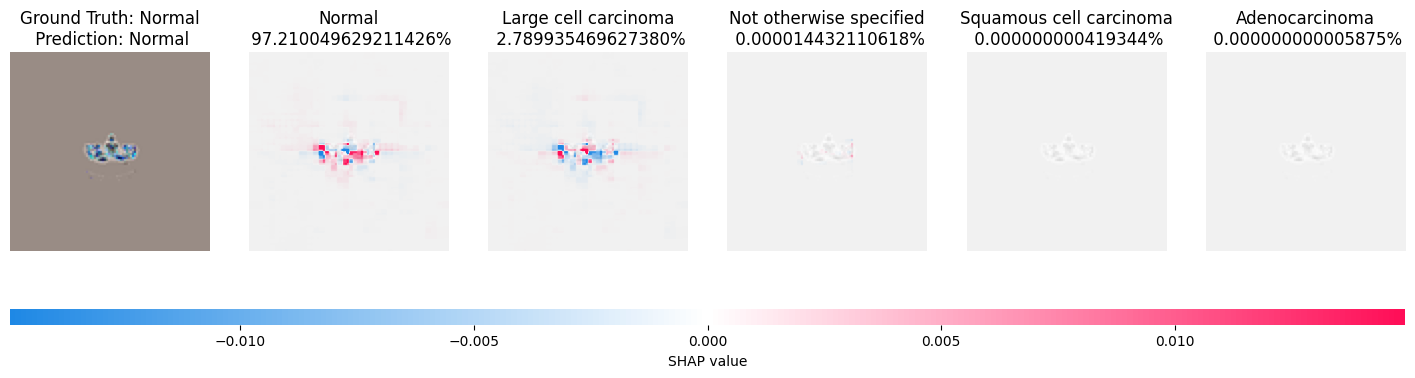

In [24]:
# Call the function to display the attributions
show_attributions(f, X_resized[1:2], y, shap_values, class_names)